# Regular LSTM with PyTorch


Import libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if not torch.cuda.is_available() else "cpu")

Import dataset


In [ ]:
data = pd.read_csv("AirPassengers.csv")
data

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


Preprocessing


In [ ]:
data["Date"] = pd.to_datetime(data["Month"])
data.drop("Month", axis=1, inplace=True)
data

,#Passengers,Date
0,112,1949-01-01
1,118,1949-02-01
2,132,1949-03-01
3,129,1949-04-01
4,121,1949-05-01
...,...,...
139,606,1960-08-01
140,508,1960-09-01
141,461,1960-10-01
142,390,1960-11-01


View Dataset


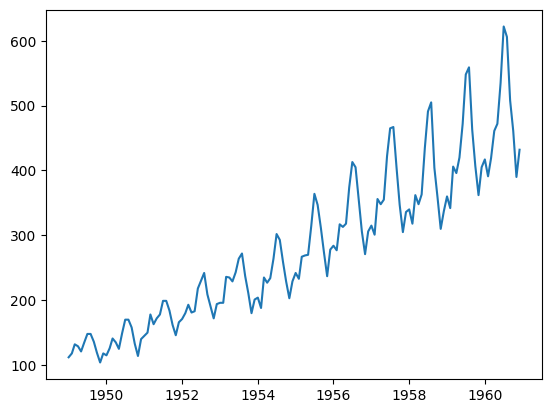

In [ ]:
plt.plot(data["Date"], data["#Passengers"])

Generate the sequence from the dataset


In [ ]:
time_series = data["#Passengers"].values

sequence_length = 5
X = []
y = []
for i in range(len(time_series) - sequence_length):
    # The input sequence is the slice from i to i + sequence_length
    sequence = time_series[i : i + sequence_length]
    X.append(sequence)

    # The target is the single value immediately after the sequence
    target = time_series[i + sequence_length]
    y.append(target)

# Convert the lists to NumPy arrays for use in ML models
X = np.array(X)
y = np.array(y)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Normalize the data


In [ ]:
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))

Transform numpy array to tensor


In [18]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

X_train = X_train.unsqueeze(2)
X_test = X_test.unsqueeze(2)

print("--- Tensors After Reshaping (Ready for LSTM) ---")
print("X_train final shape:", X_train.shape)
print("y_train final shape:", y_train.shape)
print("X_test final shape:", X_test.shape)
print("y_test final shape:", y_test.shape)

--- Tensors After Reshaping (Ready for LSTM) ---
X_train final shape: torch.Size([111, 5, 1])
y_train final shape: torch.Size([111, 1])
X_test final shape: torch.Size([28, 5, 1])
y_test final shape: torch.Size([28, 1])


### Create a Regular PyTorch LSTM


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTMCell(input_size, hidden_size)
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, sequence):
        batch_size = sequence.size(0)
        seq_length = sequence.size(1)
        h_t = torch.zeros(batch_size, self.hidden_size, device=sequence.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=sequence.device)
        output = []

        for i in range(seq_length):
            x = sequence[:, i]
            h_t, c_t = self.lstm(x, (h_t, c_t))

        output = self.dropout(h_t)
        output = self.linear(output)
        return output

Create a Data Loader


In [23]:
BATCH_SIZE = 24

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Train regular LSTM


In [ ]:
model = LSTM(input_size=X_train.shape[2], hidden_size=20, output_size=1)
model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 3000

start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)
start_event.record()

for epoch in range(epochs):
    model.train()

    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(X_batch)

        loss = loss_function(y_pred, y_batch)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            test_loss += loss_function(y_pred, y_batch).item()

    avg_test_loss = test_loss / len(test_loader)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch + 1}, Test Loss: {avg_test_loss:.4f}, Train Loss: {avg_train_loss:.4f}")

end_event.record()
torch.cuda.synchronize()  # Wait for all GPU operations to complete

elapsed_time_ms = start_event.elapsed_time(end_event)
elapsed_time_sec = elapsed_time_ms / 1000
minutes = int(elapsed_time_sec // 60)
seconds = int(elapsed_time_sec % 60)

print(f"\nTraining finished in {minutes} minutes and {seconds} seconds.")

Epoch: 10, Test Loss: 6.2070, Train Loss: 1.1125
Epoch: 20, Test Loss: 5.9885, Train Loss: 1.1066
Epoch: 30, Test Loss: 5.7712, Train Loss: 1.0584
Epoch: 40, Test Loss: 5.5611, Train Loss: 1.0110
Epoch: 50, Test Loss: 5.3445, Train Loss: 1.0153
Epoch: 60, Test Loss: 5.1131, Train Loss: 0.9066
Epoch: 70, Test Loss: 4.8729, Train Loss: 0.8865
Epoch: 80, Test Loss: 4.5993, Train Loss: 0.8498
Epoch: 90, Test Loss: 4.3108, Train Loss: 0.7785
Epoch: 100, Test Loss: 4.0057, Train Loss: 0.7810
Epoch: 110, Test Loss: 3.6614, Train Loss: 0.6882
Epoch: 120, Test Loss: 3.3024, Train Loss: 0.5977
Epoch: 130, Test Loss: 2.9437, Train Loss: 0.5631
Epoch: 140, Test Loss: 2.5951, Train Loss: 0.4545
Epoch: 150, Test Loss: 2.2644, Train Loss: 0.4134
Epoch: 160, Test Loss: 1.9799, Train Loss: 0.3764
Epoch: 170, Test Loss: 1.7472, Train Loss: 0.3889
Epoch: 180, Test Loss: 1.5745, Train Loss: 0.3347
Epoch: 190, Test Loss: 1.4392, Train Loss: 0.3563
Epoch: 200, Test Loss: 1.3368, Train Loss: 0.2876
Epoch: 21

Plot the results of the LSTM model


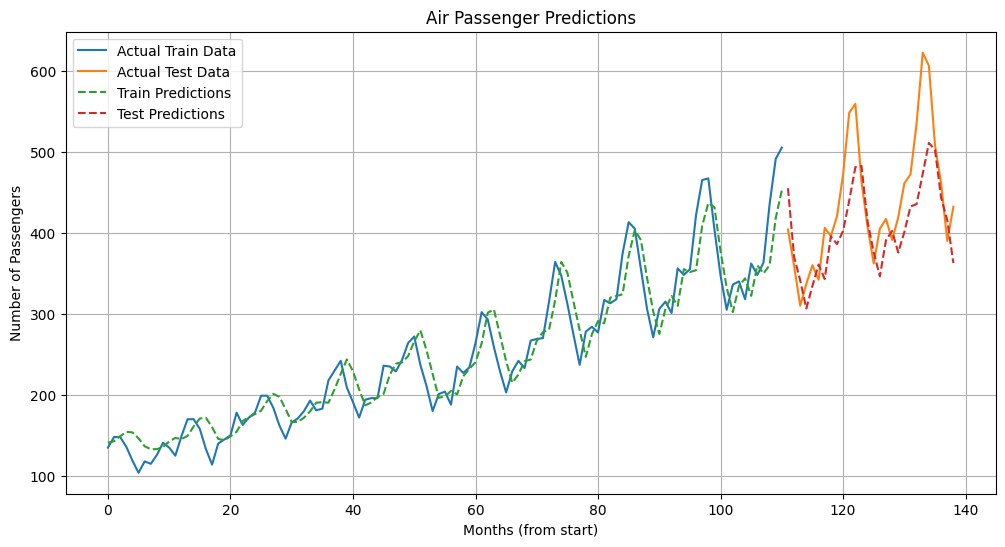

In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# --- 1. Get Predictions ---
with torch.no_grad():
    train_plot = model(X_train.to(device))
    test_plot = model(X_test.to(device))

# --- 2. Inverse Transform Data for Plotting ---
# Move tensors to CPU and convert to NumPy arrays
train_predictions = scaler_y.inverse_transform(train_plot.to("cpu").numpy())
train_actuals = scaler_y.inverse_transform(y_train.to("cpu").numpy())
test_predictions = scaler_y.inverse_transform(test_plot.to("cpu").numpy())
test_actuals = scaler_y.inverse_transform(y_test.to("cpu").numpy())

# --- 3. Create the Plot ---
plt.figure(figsize=(12, 6))

# Plot the original passenger data (actuals)
# We plot both train and test actuals together to get a continuous line
plt.plot(scaler_y.inverse_transform(y_train.numpy()), label="Actual Train Data")
plt.plot(range(len(train_actuals), len(train_actuals) + len(test_actuals)), test_actuals, label="Actual Test Data")

# Plot the training predictions
# This will start from index 0 and go up to the end of the training set
plt.plot(train_predictions, label="Train Predictions", linestyle="--")

# Plot the test predictions
# This needs a new x-axis range that starts after the training data
test_x_axis = range(len(train_predictions), len(train_predictions) + len(test_predictions))
plt.plot(test_x_axis, test_predictions, label="Test Predictions", linestyle="--")


plt.title("Air Passenger Predictions")
plt.xlabel("Months (from start)")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid(True)
plt.show()